In [3]:

from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langgraph.graph.message import AnyMessage
from dotenv import load_dotenv
load_dotenv()
import os
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages, MessagesState
from typing import Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import DuckDuckGoSearchRun
import operator
from pydantic import BaseModel
from pydantic import Field
from typing import List




In [36]:
from IPython.display import Image, display

In [17]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
)


### Simple Graph

In [30]:
# os.environ['GOOGLE_API_KEY']

In [31]:
memory = MemorySaver()

In [32]:
class State(MessagesState):
    pass
    

In [33]:
graph = StateGraph(State)

In [9]:
def model_call_node(state):
    return {"messages" : [llm.invoke(state['messages'])]}

In [10]:
graph.set_entry_point('node1')
graph.add_node('node1', model_call_node)
graph.add_edge('node1', END)

In [11]:
graph = graph.compile()

In [12]:
type(graph)

langgraph.graph.state.CompiledStateGraph

In [13]:
messages = [HumanMessage('can you explain me how you get build')]

In [14]:
state = graph.invoke({'messages': messages})

In [15]:
new_message = [HumanMessage('ok now explain me how can i do it')]

In [16]:
state['messages'] + new_message

[HumanMessage(content='can you explain me how you get build', additional_kwargs={}, response_metadata={}, id='5b0d0c99-a94b-45e0-9252-58bb8567fef8'),
 AIMessage(content='Okay, let\'s break down how I, as a large language model, am "built." It\'s a multi-faceted process involving data, architecture, training, and ongoing refinement.  Think of it like building a house: you need materials (data), a blueprint (architecture), construction workers (training algorithms), and ongoing maintenance (refinement).\n\n**1. Data: The Foundation**\n\n*   **Massive Text and Code Datasets:** I am trained on an enormous amount of text and code data. This data comes from a variety of sources, including:\n    *   **The Internet:**  Web pages, articles, blog posts, forums, and other publicly available text.\n    *   **Books:**  A vast collection of published books.\n    *   **Code Repositories:**  Code from platforms like GitHub, covering many programming languages.\n    *   **Other Sources:**  Scientific p

In [17]:
output = graph.invoke({'messages': state['messages'] + new_message})

In [18]:
print(output['messages'][-1].content)

Okay, let's break down how you can build your own language model. Be warned: building a *large* language model like me requires significant resources and expertise. However, you can definitely build smaller, simpler models to learn the concepts and gain practical experience. Here's a roadmap:

**I. Foundational Knowledge:**

*   **Programming:**  Python is the dominant language for machine learning.  You'll need to be comfortable with Python syntax, data structures, and libraries.
*   **Linear Algebra and Calculus:**  A basic understanding of these mathematical concepts is essential for understanding how neural networks work.
*   **Machine Learning Fundamentals:**  Learn the basics of machine learning, including:
    *   Supervised vs. Unsupervised Learning
    *   Neural Networks (especially feedforward networks)
    *   Backpropagation
    *   Optimization algorithms (e.g., Gradient Descent, Adam)
    *   Evaluation metrics (e.g., accuracy, precision, recall)
*   **Natural Language P

### Memory for Multi-turn Conversation

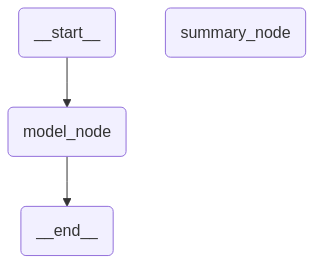

In [10]:
memory = MemorySaver()

class State(MessagesState):
    summary: str

graph = StateGraph(State)

# chat node
def model_node(state):
    summary = state.get("summary",'')
    if summary:
        system_message = f"Summmary of previous chat : {summary}"
        messages = [SystemMessage(system_message)] + state['messages']
    else:
        messages = state['messages']
        
    return {'messages': [llm.invoke(messages)]}

# Summaraize node
def summary_node(state):
    summarize_prompt = [HumanMessage('Summarize the whole chat until now , so it can be used as chat history, only generate summary nothing else')]
    history_chat = state['messages']
    model_input_for_summary = history_chat + summarize_prompt
    return {"summary": llm.invoke(model_input_for_summary)}

def condition(state):
    if len(state['messages']) > 4:
        return "summary_node"
    else:
        return END 

# Graph nodes and connections
graph.add_node('model_node', model_node)
graph.add_node(summary_node)

graph.add_edge(START, 'model_node')
graph.add_conditional_edges('model_node', condition)

graph.add_edge('summary_node', END)

# Compile graph
graph = graph.compile(checkpointer=memory)
graph

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))

AttributeError: 'StateGraph' object has no attribute 'get_graph'

In [20]:
cofig = {'configurable': {'thread_id':1}}
graph.invoke({'messages': {'role':'user','content':'who are you'}},config=cofig)

{'messages': [HumanMessage(content='who are you', additional_kwargs={}, response_metadata={}, id='74b1c451-f79b-478a-b022-96c35600d85c'),
  AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--14017446-d838-416d-bd06-5ea3a643e05e-0', usage_metadata={'input_tokens': 3, 'output_tokens': 12, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}})]}

In [23]:
graph.invoke({'messages' : [HumanMessage('who built you')]},config=cofig)

{'messages': [HumanMessage(content='who are you', additional_kwargs={}, response_metadata={}, id='74b1c451-f79b-478a-b022-96c35600d85c'),
  AIMessage(content='I am a large language model, trained by Google.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--14017446-d838-416d-bd06-5ea3a643e05e-0', usage_metadata={'input_tokens': 3, 'output_tokens': 12, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='who built you', additional_kwargs={}, response_metadata={}, id='8cf88c0e-1593-48c5-9377-fac687557722'),
  AIMessage(content='I was trained by Google.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cd1cf627-fff0-4cbd-88cb-56de8e7ec093-0', usage_metadata={'input_to

In [17]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [18]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    return {"messages": response}


In [19]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [20]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END


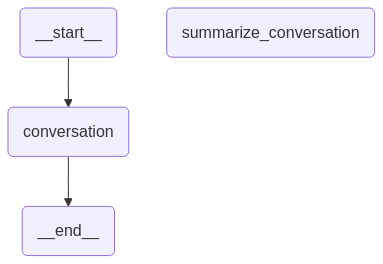

In [21]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [22]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I help you today?
================================== Ai Message ==================================

Your name is Lance. You just told me! 😊
================================== Ai Message ==================================

That's awesome! They're a great team. What do you like most about the 49ers? Are you excited for the upcoming season?


In [23]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='5e84b096-59a1-4f62-b253-f57a07682900'), AIMessage(content="Hi Lance! It's nice to meet you. How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--9d96b000-d7f6-43e0-9898-9c230cbc9f7e-0', usage_metadata={'input_tokens': 6, 'output_tokens': 19, 'total_tokens': 25, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='bdef8595-03ef-4416-9dff-3f8697290f9f'), AIMessage(content='Your name is Lance. You just told me! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--b39318ef-fcf5-4041-a0

In [24]:
graph.get_state(config).values.get("summary","")

''

In [25]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

You're right, Nick Bosa is a fantastic player! And yes, he is currently the highest-paid defensive player in the NFL. He signed a massive contract extension that made him the highest-paid at his position. He's definitely a key part of the 49ers' success.


In [26]:
graph.get_state(config).values.get("summary","")

"Okay, here's a summary of our conversation:\n\nLance introduced himself. I acknowledged him and asked how I could help. He then asked me what his name was, and I reminded him that he had just told me it was Lance. He then stated he likes the 49ers, and I responded positively, asking what he liked about them and if he was excited for the season. He replied that he likes Nick Bosa and asked if he was the highest-paid defensive player, to which I confirmed that he is."

### simple web rag


In [ ]:
class State(TypedDict):
    question: str
    answer: str
    context:Annotated[list, operator.add]
    
graph = StateGraph(State)

# Nodes
def duckduckgo_search(state):
    search = DuckDuckGoSearchRun()
    question = state['question']
    search_result = search.invoke(question)
    return {'context': [search_result]}

def wiki_search(state):
    question = state['question']
    documents = WikipediaLoader(question, load_max_docs=5).load()
    search_result = []
    for doc in documents:
        search_result.append(doc.metadata['summary'])
    
    return {'context':  search_result}

def model_call(state):
    context = '\n'.join(state['context'])
    prompt = (f"context: {context}\n Answer the question: {state['question']} using the context above, if the answer does not present in the context say it")
    return {'answer': model.invoke(prompt)}

graph.add_node('wiki', wiki_search)
graph.add_node('duck',duckduckgo_search)
graph.add_node('model', model_call)

graph.add_edge(START, 'wiki')
graph.add_edge(START, 'duck')
graph.add_edge('wiki', 'model')
graph.add_edge('duck','model')
graph.add_edge('model',END)
graph = graph.compile()

In [78]:
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [83]:
result = graph.invoke({'question':'what are the recent problem with india and pakistan'})

In [84]:
print(''.join(result['context']))

The escalating conflict between India and Pakistan, two neighbors who have been rivals for decades, erupted in the early hours of Wednesday morning when New Delhi launched missiles across the border. New Delhi said its strikes on Pakistan were both a response to last month's attack that killed at least 26 people Indian-administered Kashmir and a deterrent against future attacks, which India ... India launched military strikes on targets in Pakistan, both countries said on Wednesday and Pakistan claimed it had shot down five Indian Air Force jets, in an escalation that has pushed the two ... The conflict between India and Pakistan puts two of the world's nuclear powers head to head. ... Pakistan may also have reason to respond with more force to India's recent attack than in the past. Turkish President Recip Tayyip Erdogan has spoken with Pakistan's Prime Minister Shehbaz Sharif on a call to convey his solidarity after India hit Pakistan and Pakistani Kashmir with missiles.The partition

In [82]:
print(result['answer'].content)

The core problem between India and Pakistan is a complex and multifaceted dispute rooted in historical events, political tensions, and territorial claims. Here's a breakdown of the key issues:

*   **The Partition of British India (1947):** The division of British India into India and Pakistan led to mass displacement, violence, and lasting animosity. The partition created a legacy of mistrust and unresolved issues.

*   **Territorial Disputes, Especially Kashmir:** The primary point of contention is the region of Jammu and Kashmir. Both countries claim the territory, leading to multiple wars and ongoing conflict. The region is divided, with India, Pakistan, and China controlling different portions.

*   **Cross-Border Terrorism and Alleged Subversive Acts:** India accuses Pakistan of sponsoring cross-border terrorism, while Pakistan alleges subversive acts by India. These accusations fuel further distrust and hinder efforts to improve relations.

*   **Religious Differences:** While b

In [53]:
search = DuckDuckGoSearchRun()
question = 'algebra'
search_result = search.invoke(question)

In [55]:
search_result

'Algebra is a branch of mathematics that studies abstract systems and operations. Learn about its origin, development, and major branches, such as elementary, linear, and abstract algebra. Learn about the origin and evolution of algebra, the branch of mathematics that manipulates abstract symbols rather than numbers. Explore the ancient and modern developments of equations, number systems, and symbolic language in algebra. Algebra did not always make use of the symbolism that is now ubiquitous in mathematics; instead, it went through three distinct stages. The stages in the development of symbolic algebra are approximately as follows: [3] Rhetorical algebra, in which equations are written in full sentences. For example, the rhetorical form of x + 1 = 2 {\\displaystyle x+1=2} is "The thing plus one equals two" or ... Learn the basics of algebra, including expressions, equations, operations, and methods for solving linear and quadratic equations. Explore algebra formulas, tricks, practic

### hh

In [25]:
class Analyst(BaseModel):
    affiliation:str = Field(description='Primary Affiliation of the analyst')
    name: str = Field(description='name of the analyst')
    role: str = Field(description='role of the analyst in the context of the topic')
    description:str = Field(description='description of the analyst focus, concerns and motives')
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspective(BaseModel):
    analysts: List[Analyst] = Field(description='Comprehensive list of analyst with their roles and affiliatoins')
    
class GeneralAnalystState(TypedDict):
    topic: str
    max_analyst: str
    human_analyst_feedback: str
    analysts: List[Analyst]
    

In [6]:
# prompt
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

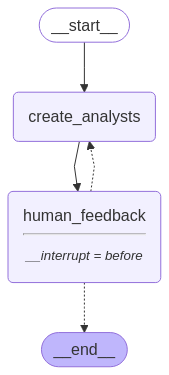

In [29]:
# node
def create_analysts(state: GeneralAnalystState):
    topic = state['topic']
    max_analyst = state['max_analyst']
    human_analyst_feedback = state.get('human_analyst_feedback','')
    structured_model = model.with_structured_output(Perspective)
    system_message = analyst_instructions.format(topic=topic,
                                                human_analyst_feedback=human_analyst_feedback,
                                                max_analyst=max_analyst)
    message = [SystemMessage(analyst_instructions),
               HumanMessage('Generate a set of Analyst')]
    output = structured_model.invoke(message)
    return {'analysts':output.analysts}

def human_feedback(state: GeneralAnalystState):
    pass

def should_continue(state: GeneralAnalystState):
    human_analyst_feedback = state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return 'create_analyst'    
    return END
    


builder = StateGraph(GeneralAnalystState)

builder.add_node('create_analysts', create_analysts)
builder.add_node('human_feedback', human_feedback)
builder.add_edge(START, 'create_analysts')
builder.add_edge('create_analysts', 'human_feedback')
builder.add_conditional_edges(
    'human_feedback',
    should_continue,
    ['create_analysts', END]
)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory, interrupt_before=['human_feedback'])
graph

In [19]:
pers = model.with_structured_output(Perspective).invoke('Generate a set of analyst')

In [21]:
pers.analyst

[Analyst(affiliation='ThinkTankA', name='John Smith', role='National Security Analyst', description='Cybersecurity threats from a national security perspective'),
 Analyst(affiliation='BankOfAmerica', name='Jane Doe', role='Financial Analyst', description='Cybersecurity threats from a financial perspective')]